In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

In [172]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False, index=None):
    """
    dataset: whole dataset (np array)
    target: target column of whole dataset (put dataset if it has single variable) (np array)
    start_index: starting index of the dataset
    end_index: ending index of the dataset (put None if end index is the last element of dataset)
    history_size: how many data points should appear in past history
    target_size: how many data points you want to predict for future
    step: step size
    single_step: is single step
    index: index array
    """
    
    data = []
    labels = []
    idx = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
        if index is not None:
            idx.append(index[i:i+target_size])

    if index is not None:
        return np.array(data), np.array(labels), np.array(idx)
    else:
        return np.array(data), np.array(labels)

In [180]:
dataset = np.sin(np.arange(300)) + np.random.rand(300)*0.7 #create a sinusoidal dataset with some randomness
dataset = dataset.reshape(len(dataset),1)
dataset[:5]

array([[ 0.55230169],
       [ 1.03751693],
       [ 1.37220875],
       [ 0.5752523 ],
       [-0.72576825]])

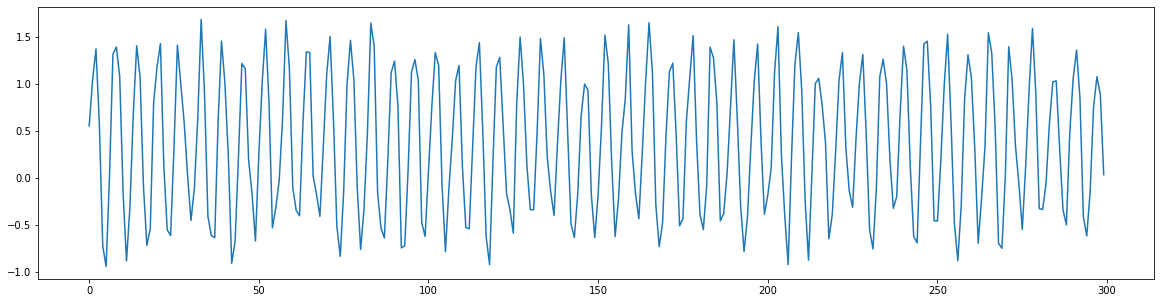

In [181]:
plt.figure(figsize=(20,5))
plt.plot(dataset)

In [182]:
#scale the data
sca = MinMaxScaler()
dataset = sca.fit_transform(dataset)

In [207]:
#train-test split and prepare data for time series

TRAIN_SPLIT = int(len(dataset)*0.7) #how many data in train
past_history = 3 #how many data to look in the past for prediction
future_target = 1 #how many data to predict in the future
STEP = 1 #step size

X_train, y_train = multivariate_data(dataset, dataset[:,0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)

X_test, y_test = multivariate_data(dataset, dataset[:,0], TRAIN_SPLIT,
                                             None, past_history,
                                             future_target, STEP)
print(X_train.shape)

#reshape dataset in case of need
if len(X_train.shape)==2:
    X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
    
if len(X_test.shape)==2:
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

(207, 3, 1)


In [208]:
X_train.shape, y_train.shape

((207, 3, 1), (207, 1))

In [209]:

model = keras.Sequential()
model.add(keras.layers.LSTM(8, input_shape=(X_train.shape[1],X_train.shape[2])))
#model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(y_train.shape[1]))

model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(0.001))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [210]:
history = model.fit(
        X_train, y_train, 
        epochs=70, 
        batch_size=4, 
        validation_split=0.1, 
        verbose=1, 
        shuffle=False
        )

Train on 186 samples, validate on 21 samples
Epoch 1/70
186/186 [==============================] - 4s 23ms/sample - loss: 0.1664 - val_loss: 0.1335
Epoch 2/70
186/186 [==============================] - 1s 3ms/sample - loss: 0.1083 - val_loss: 0.1091
Epoch 3/70
186/186 [==============================] - 1s 3ms/sample - loss: 0.0967 - val_loss: 0.0981
Epoch 4/70
186/186 [==============================] - 0s 3ms/sample - loss: 0.0868 - val_loss: 0.0876
Epoch 5/70
186/186 [==============================] - 1s 3ms/sample - loss: 0.0763 - val_loss: 0.0759
Epoch 6/70
186/186 [==============================] - 1s 6ms/sample - loss: 0.0640 - val_loss: 0.0617
Epoch 7/70
186/186 [==============================] - 1s 3ms/sample - loss: 0.0491 - val_loss: 0.0452
Epoch 8/70
186/186 [==============================] - 0s 2ms/sample - loss: 0.0335 - val_loss: 0.0301
Epoch 9/70
186/186 [==============================] - 0s 3ms/sample - loss: 0.0219 - val_loss: 0.0216
Epoch 10/70
186/186 [===============

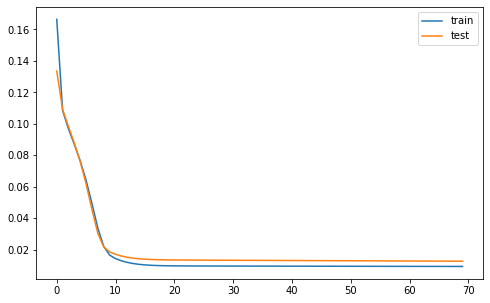

In [211]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

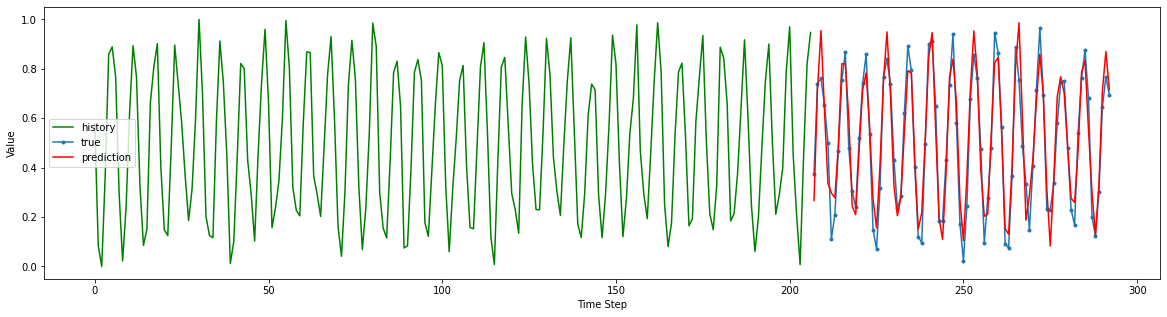

In [213]:
y_pred = model.predict(X_test)
plt.figure(figsize=(20,5))

plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

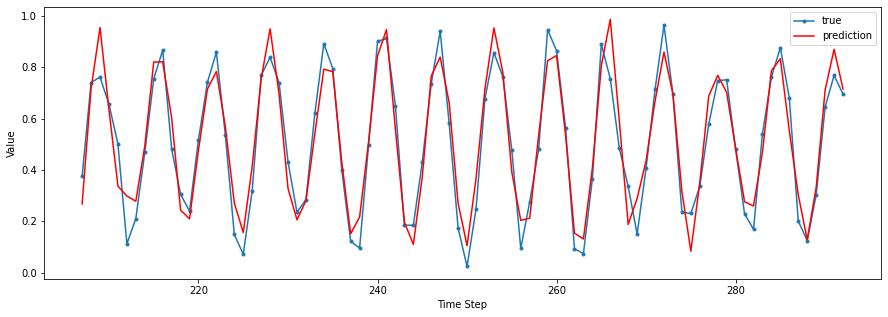

In [214]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [216]:
n = 1
X_test[n],y_test[n],y_pred[n]

(array([[0.26608627],
        [0.02553414],
        [0.37469869]]),
 array([0.74003233]),
 array([0.7166301], dtype=float32))

In [217]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])




def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    fig=plt.figure(figsize=(20,8))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        #print(series[window:])
        mae = mean_absolute_error(series[window:], rolling_mean[window:]) 
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        print(mae,deviation)
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

## ---

In [275]:
X = np.arange(500)

In [290]:
y1 = 2*X+5+10*np.random.rand(len(X))

In [303]:
y2 = 10*np.sin(X)*10*np.random.rand(len(X))

In [322]:
y = y1 + y2

#rand_points = np.random.randint(0,len(X),100)
#y[rand_points]+=2000*(np.random.rand(len(rand_points))-0.5)
#rand_points

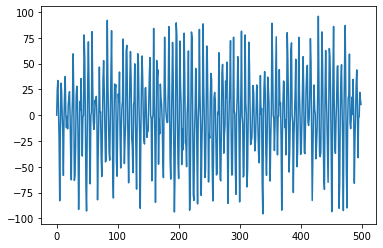

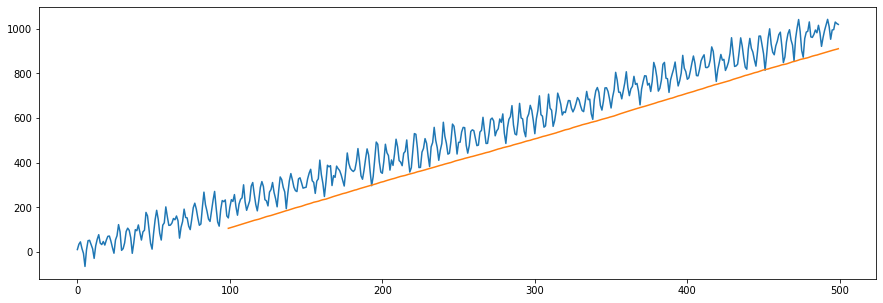

In [305]:
plt.figure(figsize=(15,5))
plt.plot(y)
plt.plot(pd.Series(y).rolling(100).mean().values)

54.80236440632583 0    42.363936
dtype: float64


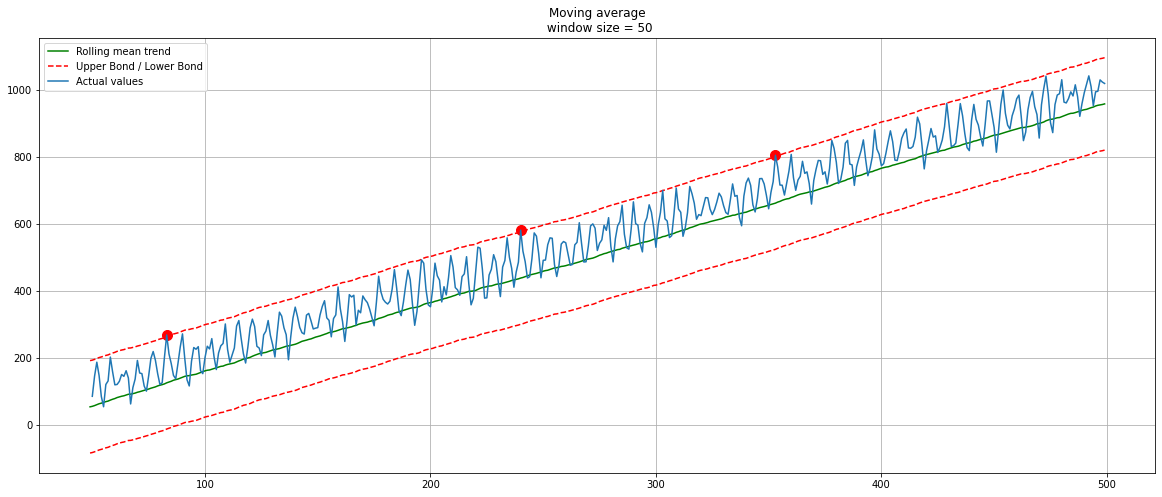

In [316]:
plotMovingAverage(pd.DataFrame(y),50,plot_intervals=True, plot_anomalies=True)

In [325]:

y2 = y2.reshape(len(dataset),1)
dataset = y2
#scale the data
sca = MinMaxScaler()
dataset = sca.fit_transform(dataset)

In [326]:
#train-test split and prepare data for time series

TRAIN_SPLIT = int(len(dataset)*0.7) #how many data in train
past_history = 10 #how many data to look in the past for prediction
future_target = 1 #how many data to predict in the future
STEP = 1 #step size


X_train, y_train = multivariate_data(dataset, dataset[:,0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)

X_test, y_test = multivariate_data(dataset, dataset[:,0], TRAIN_SPLIT,
                                             None, past_history,
                                             future_target, STEP)
print(X_train.shape)

#reshape dataset in case of need
if len(X_train.shape)==2:
    X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
    
if len(X_test.shape)==2:
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

(340, 10, 1)


In [329]:

model = keras.Sequential()
model.add(keras.layers.LSTM(12, input_shape=(X_train.shape[1],X_train.shape[2])))
#model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(y_train.shape[1]))

model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(0.001))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 12)                672       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 13        
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


In [330]:
history = model.fit(
        X_train, y_train, 
        epochs=35, 
        batch_size=4, 
        validation_split=0.1, 
        verbose=1, 
        shuffle=False
        )

Train on 306 samples, validate on 34 samples
Epoch 1/35
306/306 [==============================] - 5s 16ms/sample - loss: 0.0837 - val_loss: 0.0349
Epoch 2/35
306/306 [==============================] - 2s 5ms/sample - loss: 0.0567 - val_loss: 0.0340
Epoch 3/35
306/306 [==============================] - 1s 5ms/sample - loss: 0.0555 - val_loss: 0.0332
Epoch 4/35
306/306 [==============================] - 2s 5ms/sample - loss: 0.0543 - val_loss: 0.0323
Epoch 5/35
306/306 [==============================] - 2s 7ms/sample - loss: 0.0528 - val_loss: 0.0313
Epoch 6/35
306/306 [==============================] - 2s 6ms/sample - loss: 0.0508 - val_loss: 0.0298
Epoch 7/35
306/306 [==============================] - 2s 5ms/sample - loss: 0.0477 - val_loss: 0.0276
Epoch 8/35
306/306 [==============================] - 2s 7ms/sample - loss: 0.0421 - val_loss: 0.0275
Epoch 9/35
306/306 [==============================] - 3s 10ms/sample - loss: 0.0351 - val_loss: 0.0264
Epoch 10/35
306/306 [==============

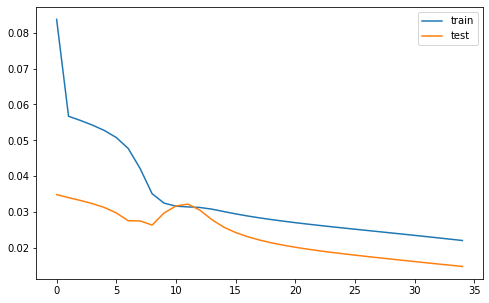

In [331]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

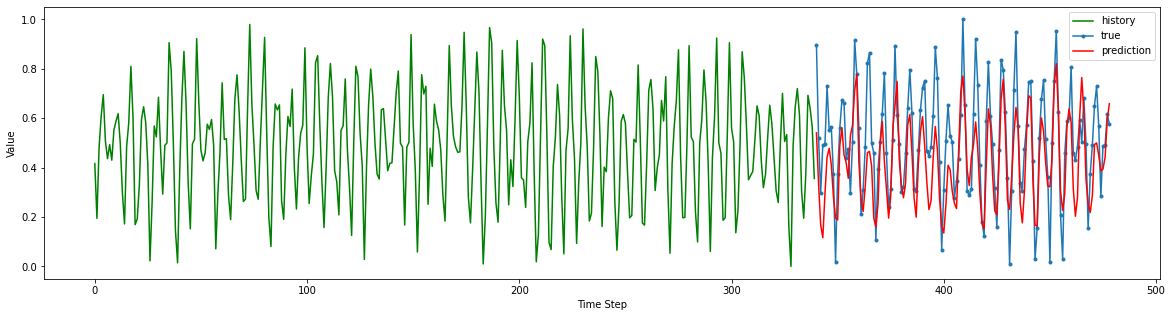

In [332]:
y_pred = model.predict(X_test)
plt.figure(figsize=(20,5))

plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

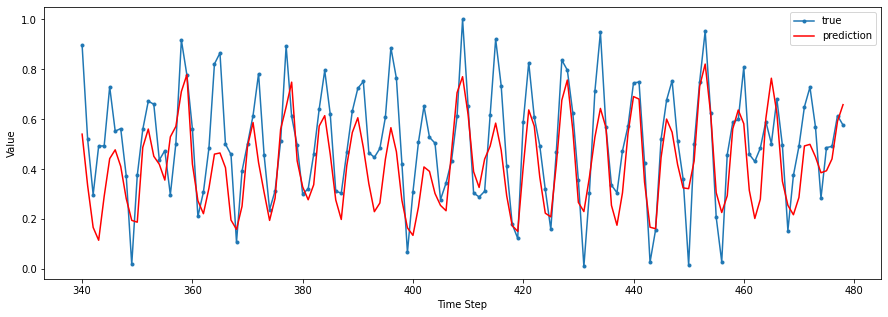

In [333]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [334]:
y_pred

array([[0.5407114 ],
       [0.3348217 ],
       [0.16760401],
       [0.11613503],
       [0.2917582 ],
       [0.44271228],
       [0.47791386],
       [0.41182813],
       [0.28280362],
       [0.19564484],
       [0.18838929],
       [0.48785898],
       [0.5611313 ],
       [0.45207357],
       [0.4201378 ],
       [0.3568446 ],
       [0.5297596 ],
       [0.5714715 ],
       [0.7111091 ],
       [0.7788707 ],
       [0.42100272],
       [0.2741596 ],
       [0.22237091],
       [0.32433262],
       [0.46071795],
       [0.4653923 ],
       [0.40642   ],
       [0.19694953],
       [0.15946768],
       [0.2521206 ],
       [0.49245575],
       [0.5871675 ],
       [0.42669615],
       [0.3083626 ],
       [0.19550537],
       [0.2846969 ],
       [0.5598766 ],
       [0.6499063 ],
       [0.7487179 ],
       [0.43390077],
       [0.32963872],
       [0.2781168 ],
       [0.33824718],
       [0.5733314 ],
       [0.6145849 ],
       [0.45989722],
       [0.27751774],
       [0.199